# type 2 test influence diagram modelling validation

- create the code for the type 2 test
  
  

In [64]:
# enable autoreload of changes in accompanying code files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### necessary imports en settings

In [65]:
import os
import sys
import re
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from IPython.display import display, HTML, clear_output, Image
import pandas as pd
from itertools import product
import math
from deepdiff import DeepDiff

In [66]:
sys.path.insert(1, "/workspaces/ou-af/problem2/")

In [67]:
# import code
import src.oopnclasses as oopnclasses
import src.oopnbuilder as oopnbuilder
import src.diagrambuilder as diagrambuilder
import src.testobservereplace as testobservereplace
import src.testchangeinput as testchangeinput
import specs.components as componentspecs
import specs.connections as connectionspecs
import specs.assemblies as assemblyspecs
import specs.tests as testspecs
import specs.testmappings as testmappingspecs

In [68]:
# Styling notebook
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML("<style>" + styles + "</style")

css_styling()

### methods to visualize diagram

In [69]:
def visualizeStructure(diagram):
#    display(HTML("<style>.container { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=60)
    
def createUtilityRow(nodelist):
    row_elements = [diagram.utility(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def createCptRow(nodelist):
    row_elements = [diagram.cpt(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def showCPTs(diagram):
    nodes = diagram.nodes()
    for n in nodes:
        if(diagram.isChanceNode(n)):
            gnb.flow.row(diagram.cpt(n))
            
def getDiagramChanceNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isChanceNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printCptTables(diagram, system):
    for component in system.getComponents():
        print("CPT tables for component: " + component.getName())
        createCptRow(getDiagramChanceNodeIdsForComponent(component.getName(), diagram))
        
def getDiagramUtilityNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isUtilityNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printUtilityTables(diagram, system):
    for component in system.getComponents():
        print("Utility tables for component: " + component.getName())
        createUtilityRow(getDiagramUtilityNodeIdsForComponent(component.getName(), diagram))

## generating influence diagram for a type 2 test

### loading system description

In [265]:
assembly = {
    "components"  : [componentspecs.light, componentspecs.switch],
    "connections" : [connectionspecs.wire, connectionspecs.wire2],
    "structure"   : assemblyspecs.structure1,   # light, switch en wire bb
    "tests"       : [testspecs.observeorreplacetest, testspecs.changeinputtest],
    "testmapping" : testmappingspecs.testmapping5     # geen testen want de test wordt hieronder handmatig toegevoegd
}

### toevoegen systemhealth
- uitbreiden beschrijving assembly met variabele systemhealth: yes/no
- oopnclasses.py, toevoegen class SystemHealth met een naam en inkomende healthnodes
- oopnbuilder.py, toevoegen methode om systemhealth aan te maken en methode om healthnodes te verzamelen
- oopnbuilder.py, uitbreiden aanmaken oopn object met systemhealth
- diagrambuilder.py, toevoegen addSystemHealth aan main


### generate OOPN

In [327]:
oopn = oopnbuilder.OopnBuilder(assembly).getOopn()

start building system: structure1
number of components: 2
number of connections: 1
added systemHealth
adding component: Switchcopy
adding component: Lightcopy
adding connection Wirecopy between: Switchcopy and Lightcopy with healthnode: healthWire
<UtilityChangeInputTestSwitch:0|PresentPowerInputsSwitch:yes>
number of tests: 1


### generate influence diagram from OOPN

In [328]:
# create diagram object en bouw influence diagram obv OOPN
diagram = gum.InfluenceDiagram()
diagram = diagrambuilder.diagramBuilder(diagram, oopn)

adding component: Light
adding component: Switch
adding component: Switchcopy
node not added, already exists in diagramEnabledStateInputsSwitch
node not added, already exists in diagramhealthSwitch
adding component: Lightcopy
node not added, already exists in diagramhealthLight
adding connection between: PresentPowerOutputsSwitch and: PresentPowerInputsLight
adding connection between: PresentPowerOutputsSwitchcopy and: PresentPowerInputsLightcopy
node not added, already exists in diagramhealthWire
adding cpt for component: Light
adding cpt for component: Switch
adding cpt for component: Switchcopy
adding cpt for component: Lightcopy
adding cpt for connection: Wire
adding cpt for connection: Wirecopy
adding systemHealth variable: 
adding systemhealth connections
adding test: ChangeInputTest
adding node: DecisionChangeInputTestSwitch
adding node: UtilityChangeInputTestSwitch
add edge from: DecisionChangeInputTestSwitch to: PresentPowerInputsSwitchcopy
add edge from: PresentLightOutputsLi

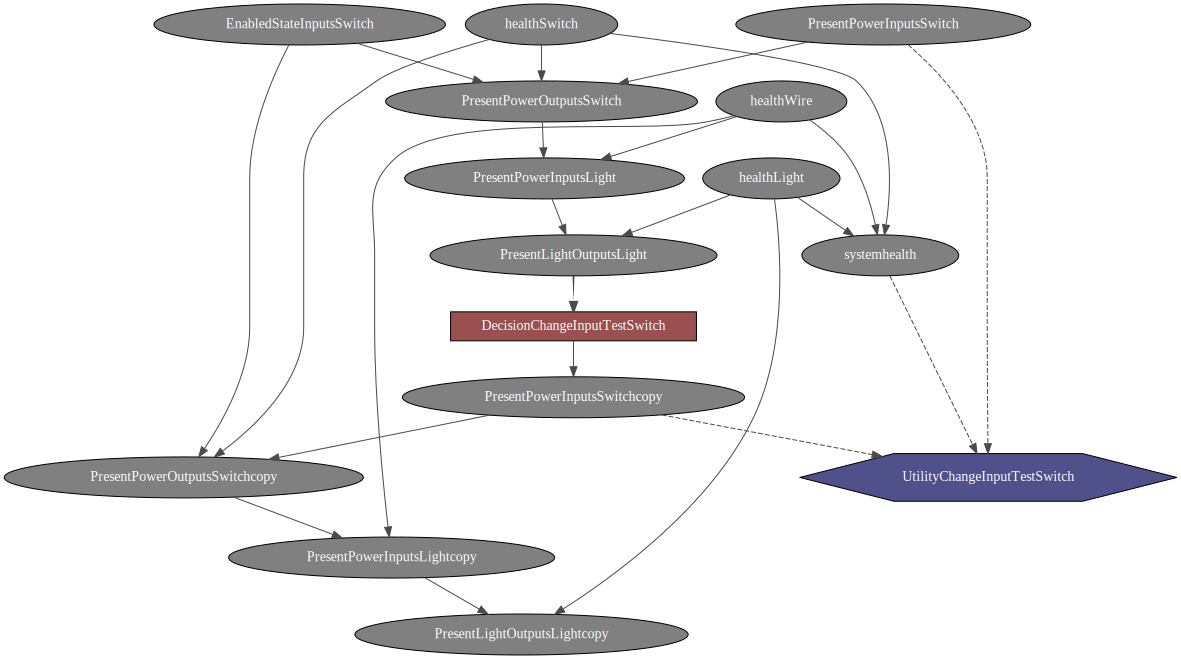

In [329]:
# tussenstand bekijken
gnb.showInfluenceDiagram(diagram, size=60)

### conditional probability table for system health

In [330]:
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"ok", "healthWire":"ok", "healthSwitch":"ok"}] = [0.99, 0.01]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"ok", "healthWire":"ok", "healthSwitch":"broken"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"ok", "healthWire":"broken", "healthSwitch":"ok"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"ok", "healthWire":"broken", "healthSwitch":"broken"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"broken", "healthWire":"ok", "healthSwitch":"ok"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"broken", "healthWire":"ok", "healthSwitch":"broken"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"broken", "healthWire":"broken", "healthSwitch":"ok"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))[{"healthLight":"broken", "healthWire":"broken", "healthSwitch":"broken"}] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("systemhealth"))


(pyAgrum.Potential<double>@0x13c874f0) 
                    ||  systemhealth     |
health|health|health||ok       |broken   |
------|------|------||---------|---------|
ok    |ok    |ok    || 0.9900  | 0.0100  |
broken|ok    |ok    || 0.0100  | 0.9900  |
ok    |broken|ok    || 0.0100  | 0.9900  |
broken|broken|ok    || 0.0100  | 0.9900  |
ok    |ok    |broken|| 0.0100  | 0.9900  |
broken|ok    |broken|| 0.0100  | 0.9900  |
ok    |broken|broken|| 0.0100  | 0.9900  |
broken|broken|broken|| 0.0100  | 0.9900  |

### configuratie utility

In [331]:
ok, broken = "ok", "broken"
yes, no = "yes", "no"
health, inputcopy, inputswitch = "systemhealth", "PresentPowerInputsSwitchcopy", "PresentPowerInputsSwitch"
id = diagram.idFromName("UtilityChangeInputTestSwitch")
diagram.utility(id)[{health:ok,inputcopy:yes,inputswitch:yes}]     = 90  # indien ok dan zelfde input
diagram.utility(id)[{health:ok,inputcopy:yes,inputswitch:no}]      = -10 # indien health ok dan niet input wisselen
diagram.utility(id)[{health:ok,inputcopy:no,inputswitch:yes}]      = -10 # indien health ok dan niet input wisselen
diagram.utility(id)[{health:ok,inputcopy:no,inputswitch:no}]       = 90  # indien ok dan zelfde input
diagram.utility(id)[{health:broken,inputcopy:yes,inputswitch:yes}] = -50 # indien broken dan niet input gelijk houden
diagram.utility(id)[{health:broken,inputcopy:yes,inputswitch:no}]  = 100 # indien broken dan andere input
diagram.utility(id)[{health:broken,inputcopy:no,inputswitch:yes}]  = 100 # indien broken dan andere input
diagram.utility(id)[{health:broken,inputcopy:no,inputswitch:no}]   = -50


In [332]:
diagram.utility(diagram.idFromName("UtilityChangeInputTestSwitch"))

(pyAgrum.Potential<double>@0x13f3d1f0) 
                    ||  Utility|
Presen|system|Presen||0        |
------|------|------||---------|
yes   |ok    |yes   || 90.0000 |
no    |ok    |yes   || -10.0000|
yes   |broken|yes   || -50.0000|
no    |broken|yes   || 100.0000|
yes   |ok    |no    || -10.0000|
no    |ok    |no    || 90.0000 |
yes   |broken|no    || 100.0000|
no    |broken|no    || -50.0000|

### uitbreiden cpt input van gedupliceerde keten

In [333]:
diagram.cpt(diagram.idFromName("PresentPowerInputsSwitchcopy"))[1] = [0.01, 0.99]
diagram.cpt(diagram.idFromName("PresentPowerInputsSwitchcopy"))

(pyAgrum.Potential<double>@0x133d4490) 
      ||  PresentPowerInput|
Decisi||yes      |no       |
------||---------|---------|
yes   || 0.9900  | 0.0100  |
no    || 0.0100  | 0.9900  |

### Unit test 1, combinaties input en output > effect op decision

In [340]:
evs = {
# input / output evidence van systeem, normaal gedrag is dus 0/0 of 1/1
'PresentPowerInputsSwitch':0,  # 1 is yes, 1 is no
'PresentLightOutputsLight':1,  # 0 is yes, 1 is no


# instellen additionele input
#'EnabledStateInputsSwitch':0,  # 0 is yes, 1 is no
}

In [341]:
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))



wordt de juiste input voor de gedupliceerde keten ingesteld?
- test 1:
  - Given: evidence input / output systeem beide 0 (yes) 
  - When: inference
  - Then: wordt de input overgenomen voor de gedupliceerde keten
  - Result: ja gebeurt
- test 2:
  - Given: evidence input / output systeem beide 1 (no) 
  - When: inference
  - Then: wordt de input overgenomen voor de gedupliceerde keten
  - Result: ja gebeurt
- test 3:
  - Given: evidence input 1 (no) en output 0 (yes)
  - When: inference
  - Then: wordt de input copy: 0 (yes)
  - Result: gebeurt niet
- test 4:
  - Given: evidence input 0 (yes) en output 1 (no)
  - When: inference
  - Then: wordt de input copy: 1 (no)
  - Result: gebeurt wel

een na laatste test gaat niet goed 


### OPNIEUW DOEN unit test 2, verwerken extra observatie, betere inschatting health?

In [342]:
evs = {
# input / output evidence van systeem, normaal gedrag is 0/0 of 1/1
'PresentPowerInputsSwitch':0,  # 0 is yes, 1 is no
'PresentLightOutputsLight':1,  # 0 is yes, 1 is no


# instellen additionele input
'EnabledStateInputsSwitch':0,  # 0 is yes, 1 is no
    
# instellen observaties mbt duplicate chain
'PresentPowerInputsSwitchcopy':1,  # 0 is yes, 1 is no
'PresentLightOutputsLightcopy':1,  # 0 is yes, 1 is no


}

In [343]:
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))

- indien originele observatie switch:aan maar lamp:uit
- en extra observatie is: switch:uit en lamp: uit
- waarbij prior van alle healths 99% is

dan is de health zonder de extra observatie > daarna met de extra observatie
- healthSwitch: 85,45% > 83,27%
- healthWire: 72,40% > 83,27%
- healthLight: 84,88% > 82,77%

dus eerst is de wire de verdachte maar daarna de lamp al ligt het dan dichter bij elkaar

### OPNIEUW DOEN indien health van wire lager wordt...
- healht wire wordt 80%

health zonder observatie en daarna met...
- healthSwitch: 86,34% > 83,9%
- healthWire: 67,95% > 80,08%
- healthLight: 85,75% > 83,39%

### OPNIEUW DOEN indien health van light lager wordt

- healthSwitch: 85,92% > 83,89%
- healthWire: 73,29% > 83,89%
- healthLight: 81,94% > 79,52%

In [ ]:
diagram.cpt(diagram.idFromName("healthWire"))